In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing as preprocessing
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [138]:
file_path = "/content/drive/MyDrive/AI/Olympic AI/Practice/Subcial depression/train_IOAI.csv"
df = pd.read_csv(file_path)
df.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Dsiidh,Female,28.0,Kalyan,Student,NaN,3.0,NaN,5.56,1.0,NaN,More than 8 hours,Unhealthy,BE,Yes,12.0,2.0,Yes,0
1,1,Drsah,Male,35.0,Varanasi,Working Professional,Teacher,NaN,2.0,NaN,NaN,1.0,Less than 5 hours,Healthy,BBA,No,5.0,4.0,No,0
2,2,Siraaam,Female,24.0,Nagpur,Student,NaN,5.0,NaN,8.08,4.0,NaN,More than 8 hours,Moderate,BBA,Yes,3.0,2.0,Yes,0
3,3,Husatr,Male,50.0,Varanasi,Working Professional,Pilot,NaN,4.0,NaN,NaN,2.0,Less than 5 hours,Healthy,PhD,Yes,8.0,1.0,Yes,0
4,4,Aaknmy,Male,45.0,Hyderabad,Working Professional,Teacher,NaN,5.0,NaN,NaN,3.0,Less than 5 hours,Moderate,B.Arch,Yes,4.0,2.0,Yes,0


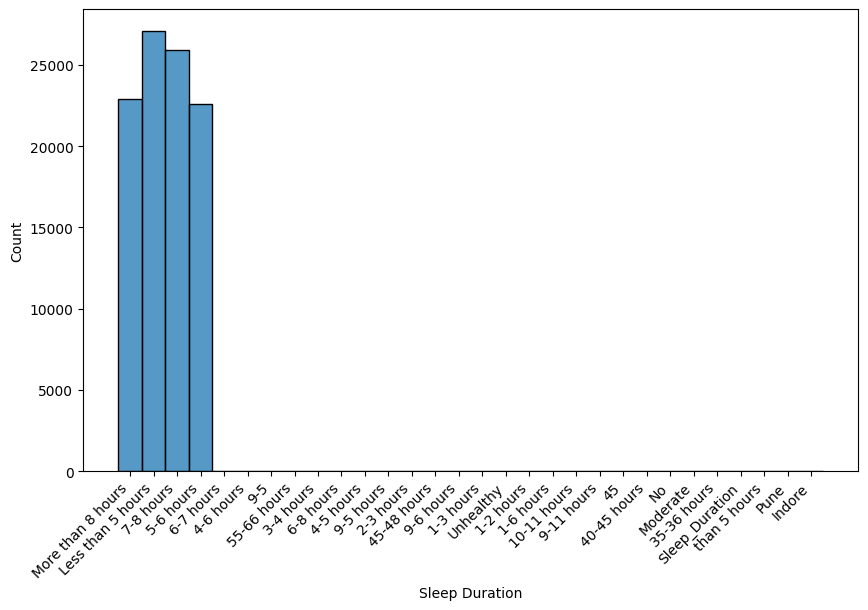

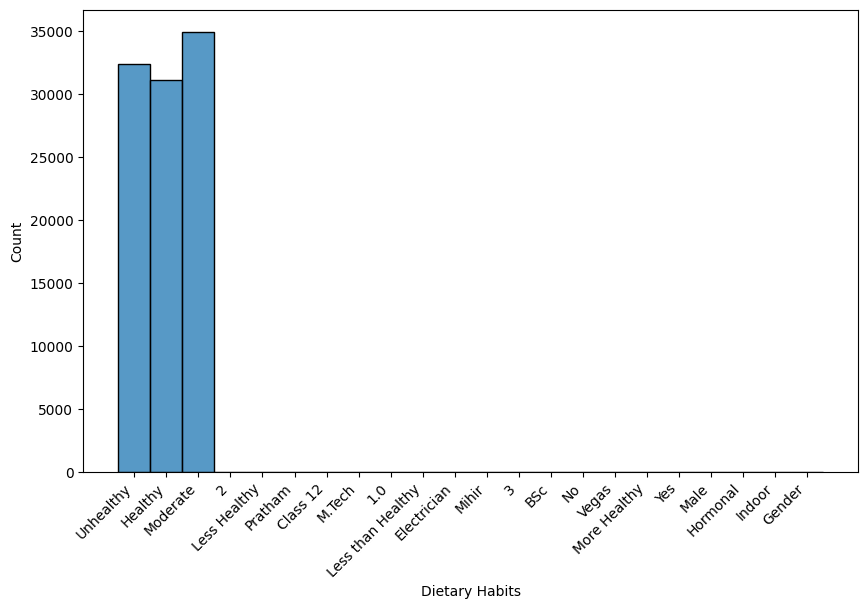

In [139]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Sleep Duration')
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Dietary Habits')
plt.xticks(rotation=45, ha='right')
plt.show()

# Preprocessing data
- Drop cột id, Name, City, CGPA, Degree, tạm thời drop Profession sau đó mã hoá sau
- Gộp Study Satisfaction và Job Satisfaction, Academic Pressure và Work Pressure,
- Mã hoá Working Professional or Student, Sleep Duration, Dietary Habits, Family History of Mental Illness,
- Xử lý null

**Delete, Merge**

In [140]:
df['Academic Pressure'] = df['Academic Pressure'].fillna(0)
df['Work Pressure'] = df['Work Pressure'].fillna(0)
df['Study Satisfaction'] = df['Study Satisfaction'].fillna(0)
df['Job Satisfaction'] = df['Job Satisfaction'].fillna(0)


df['Pressure'] = df['Academic Pressure'] + df['Work Pressure']
df['Satisfaction'] = df['Study Satisfaction'] + df['Job Satisfaction']

df.drop(columns=['id', 'Name', 'Gender', 'City', 'CGPA', 'Degree', 'Profession', 'Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction'], inplace=True)
df.head()


,Age,Working Professional or Student,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Pressure,Satisfaction
0,28.0,Student,More than 8 hours,Unhealthy,Yes,12.0,2.0,Yes,0,3.0,1.0
1,35.0,Working Professional,Less than 5 hours,Healthy,No,5.0,4.0,No,0,2.0,1.0
2,24.0,Student,More than 8 hours,Moderate,Yes,3.0,2.0,Yes,0,5.0,4.0
3,50.0,Working Professional,Less than 5 hours,Healthy,Yes,8.0,1.0,Yes,0,4.0,2.0
4,45.0,Working Professional,Less than 5 hours,Moderate,Yes,4.0,2.0,Yes,0,5.0,3.0


**Encoder**

In [141]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Family History of Mental Illness'] = le.fit_transform(df['Family History of Mental Illness'])
df['Have you ever had suicidal thoughts ?'] = le.fit_transform(df['Have you ever had suicidal thoughts ?'])
df['Working Professional or Student'] = le.fit_transform(df['Working Professional or Student'])

map_sleep = {
    'Less than 5 hours' : 1,
    '5-6 hours' : 2,
    '7-8 hours' : 3,
    'More than 8 hours' : 4
}

df['Sleep Duration'] = df['Sleep Duration'].map(map_sleep)

map_diet = {
    'Unhealthy' : 1,
    'Moderate' : 2,
    'Healthy' : 3
}

df['Dietary Habits'] = df['Dietary Habits'].map(map_diet)

df.head()

,Age,Working Professional or Student,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Pressure,Satisfaction
0,28.0,0,4.0,1.0,1,12.0,2.0,1,0,3.0,1.0
1,35.0,1,1.0,3.0,0,5.0,4.0,0,0,2.0,1.0
2,24.0,0,4.0,2.0,1,3.0,2.0,1,0,5.0,4.0
3,50.0,1,1.0,3.0,1,8.0,1.0,1,0,4.0,2.0
4,45.0,1,1.0,2.0,1,4.0,2.0,1,0,5.0,3.0


**Missing value**
- Cột sleep duration và dietary habits bị thiếu do dữ liệu bị sai -> xoá

In [142]:
print(df.shape[0])
df.isnull().sum()

98490


,0
Age,0
Working Professional or Student,0
Sleep Duration,54
Dietary Habits,23
Have you ever had suicidal thoughts ?,0
Work/Study Hours,0
Financial Stress,1
Family History of Mental Illness,0
Depression,0
Pressure,0


In [143]:
df.dropna(axis=0, inplace=True)
print(df.shape[0])

98412


# Visualizing data

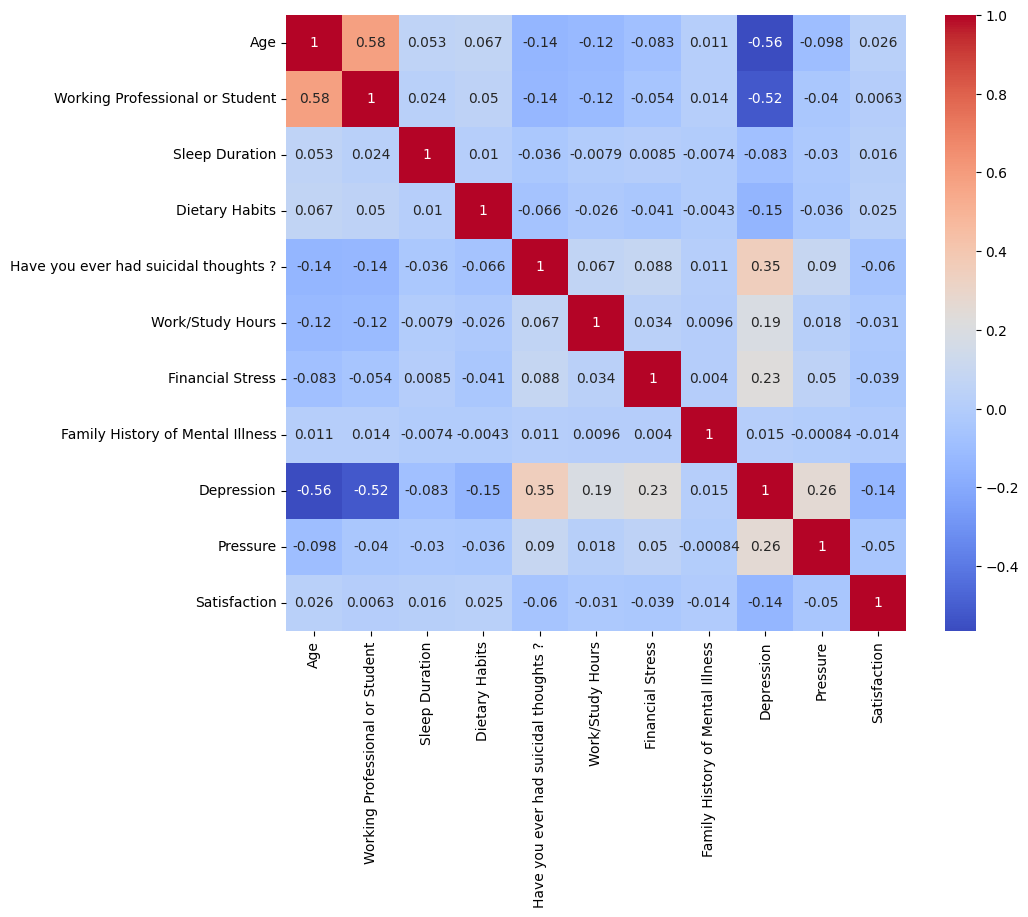

In [144]:
corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

# Splitting data

In [145]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('Depression', axis=1)
y = df['Depression']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# XGBOOST

In [146]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

model_xgboost = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(y)),
                              n_estimators=200, learning_rate=0.005, max_depth=10,
                              use_label_encoder=False, eval_metric='mlogloss')

model_xgboost.fit(X_train, y_train)
y_pred_xgboost = model_xgboost.predict(X_test)

accuracy_xgboost = accuracy_score(y_test, y_pred_xgboost)
print(f"Accuracy: {accuracy_xgboost}")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:20:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9345120154448001


# Decision Tree

In [147]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=9, random_state=50)
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy}")

Accuracy: 0.930650815424478


# Random Forest

In [148]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=50)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9334959101762943


# Logistic Regression

In [149]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9372046944063405
